In [478]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score
import random

from sklearn.utils import resample

In [479]:
class UNet(nn.Module):
    def __init__(self, embedding_size=64):
        super(UNet, self).__init__()

        # Define the encoder part
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Define the bottleneck part
        self.bottleneck_conv = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7*7*64, embedding_size)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv2(x))
        x = self.pool(x)

        # Bottleneck
        x = F.relu(self.bottleneck_conv(x))
        x = self.flatten(x)
        x = self.fc(x)

        return x

unet = UNet()

In [480]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [481]:
def split_data(train_dataset):
    data = {}
    for x in range(10):
        data[x] = [data for data in train_dataset if data[1] == x]
        random.shuffle(data[x])
    return data

In [482]:
def create_biased_dataset(data, probs):
    '''
    probs: [p_0, p_1, ..., p_9]
    returns a biased dataset according to probs
    '''
    max_p = max(probs)
    max_x = np.argmax(probs)
    max_n = 0.9 * len(data[max_x])
    res = []
    for x, lis in data.items():
        n = int(max_n * probs[x] / max_p)
        res += random.sample(data[x], n)
#         res += data[x][:n]
    random.shuffle(res)
    return res

In [483]:
def encode_data(dataset):
  unet.eval() # UNet
  return [(unet(image.unsqueeze(0)), label) for image, label in dataset]

In [484]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cpu	CPU


In [485]:
class BiasedRandomForestClassifier(RandomForestClassifier):
    def __init__(self,
                 n_estimators=100,
                 criterion='gini',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features='sqrt',
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.0,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0,
                 warm_start=False,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None,
                n_classes = 10):

        super(BiasedRandomForestClassifier, self).__init__(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples)
        
        self.n_classes = n_classes
        self.thresholds = [1/self.n_classes for _ in range(self.n_classes)]

    def fit(self, X, y, sample_weight=None):
        return super(BiasedRandomForestClassifier, self).fit(X, y, sample_weight)

    def fit_thresholds(self, X, y, alpha = 0.01, batches = 50, sample_weight = None):
        X_batches = np.array_split(X, batches)
        y_batches = np.array_split(y, batches)
        cnt = 0
        for X_batch, y_batch in zip(X_batches, y_batches):
            cnt += 1
            y_pred = self.predict(X_batch)
            for y_p, y in zip(y_pred, y_batch):
                if y_p != y:
                    diff = alpha * self.thresholds[y]
                    self.thresholds[y_p] += diff
                    self.thresholds[y] -= diff
#             print('Batch No: ', cnt, '\nThresholds: ', self.thresholds)
        return self.thresholds

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba - self.thresholds, axis = 1)
    
    def predict_biased_label_shift(self, X, train_ratios, test_ratios):
        proba = self.predict_proba(X)
        for i in range(10):
            proba[:, i] *= test_ratios[i] / train_ratios[i]
        proba /= proba.sum(axis = 1, keepdims = True)
        return np.argmax(proba - self.thresholds, axis = 1)
    
    def predict_biased_online(self, X, y, alpha = 0.01):
        res = []
        threshold_history = []
        probs_history = []
        for (xi, yi) in zip(X, y):
            proba = self.predict_proba([xi])
            predicted_class = np.argmax(proba - self.thresholds, axis = 1)[0]
#             gamma = np.max(proba - self.thresholds, axis = 1)[0]
            res.append(predicted_class)

            threshold_history.append(self.thresholds.copy())
#             gamma_prev = gamma_history[-1].copy()
#             gamma_prev[predicted_class] = min(gamma_prev[predicted_class], gamma)
#             gamma_history.append(gamma_prev)
            probs_history.append(proba)

            if predicted_class != yi:
                diff = alpha * self.thresholds[yi]
                self.thresholds[predicted_class] += diff
                self.thresholds[yi] -= diff
#                 for i in range(self.n_classes):
#                     if i == yi:
#                         continue
#                     self.thresholds[i] += diff/(self.n_classes - 1)
        return np.array(res), threshold_history, probs_history
    
    def reset_thresholds(self):
        self.thresholds = [1/self.n_classes for _ in range(self.n_classes)]

In [523]:
# code to draw a graph of majority changes over each iterations

def plot_threshold_history(threshold_history):
    """
    Plots the history of threshold values over iterations with distinct colors for each threshold.

    Args:
    threshold_history (list of list of float): A list where each element 
                                               is a list of threshold values 
                                               at a certain iteration.
    """
    # Transpose the threshold_history to get a list for each threshold across all steps
    transposed_history = list(zip(*threshold_history))

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Plot each threshold's history
    for i, history in enumerate(transposed_history):
        plt.plot(history, label=f'Threshold {i}')

    # Labeling the plot
    plt.xlabel('Iteration')
    plt.ylabel('Threshold Value')
    plt.title('Threshold Values Over Iterations')
    plt.legend()

    # Display the plot
    plt.show()

In [487]:
unet.eval()  # Set the model to evaluation mode

# Get one batch of images from the train loader
images, labels = next(iter(train_loader))

# Select the first image from this batch
# The shape of 'image' will be [1, 1, 28, 28], which is what the model expects
image = images[0].unsqueeze(0)

# Forward pass to get the embedding
embedding = unet(image)

embedding.shape

torch.Size([1, 64])

In [488]:
encoded_train = encode_data([data for data in train_dataset])

In [493]:
def make_biased_dataset(balanced_data, ratios):
    biased_datasets = {}
    encoded_biased_datasets = {}
    data = split_data(balanced_data)
    n = 10
    for ratio in ratios:
        probs = [ratio] + [(1 - ratio)/(n - 1)] * (n -1)
        biased_datasets[ratio] = create_biased_dataset(data, probs)
        encoded_biased_datasets[ratio] = encode_data(biased_datasets[ratio])
        
    return encoded_biased_datasets

def get_exp_probs(ratio):
    #want e^(-alpha * 9) = ratio, alpha = -ln(ratio) / 9
    alpha = -np.log(ratio)/9
    probs = [np.exp(-alpha * i) for i in range(10)]
    return np.array(probs)/np.sum(probs)

def make_biased_dataset_exponential(balanced_data, ratios):
    biased_datasets = {}
    encoded_biased_datasets = {}
    data = split_data(balanced_data)
    n = 10
    for ratio in ratios:
        probs = get_exp_probs(ratio)
        biased_datasets[ratio] = create_biased_dataset(data, probs)
        encoded_biased_datasets[ratio] = encode_data(biased_datasets[ratio])
        
    return encoded_biased_datasets

exponential_ratios = [1/x for x in range(1, 10, 1)]
# exponential_ratios = [0.05, 0.0501, 0.0502, 0.0503, 0.0504]
ratios = [x/10 for x in range(1, 10, 1)]
encoded_test = make_biased_dataset(test_dataset, ratios)

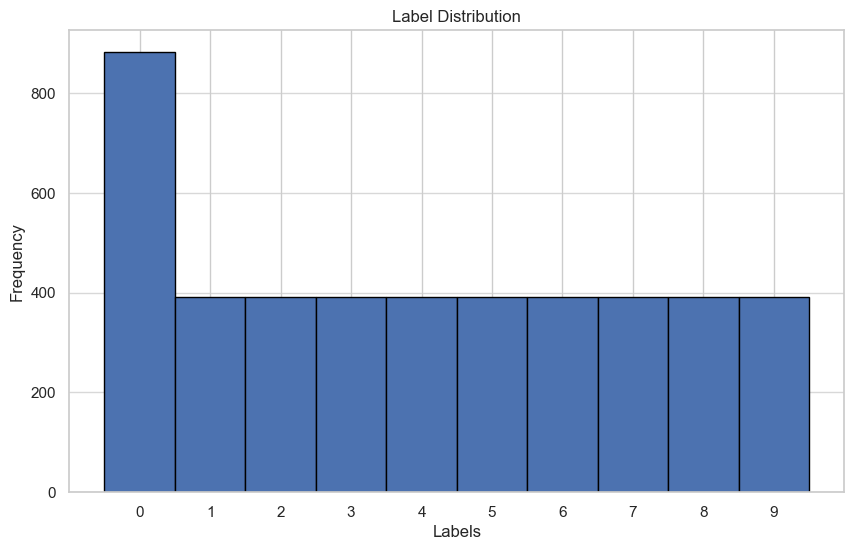

In [494]:
y_t = [encoded_test[0.2][i][1] for i in range(len(encoded_test[0.2]))]
def plot_label_distribution(y, title="Label Distribution", xlabel="Labels", ylabel="Frequency"):
    """
    Plots a histogram showing the distribution of labels.

    Parameters:
    y (array-like): Array of labels.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    # Use 'bins' to create a bin for each unique label
    plt.hist(y, bins=np.arange(np.min(y), np.max(y) + 2) - 0.5, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Set x-ticks to be at the center of each bin
    plt.xticks(np.arange(np.min(y), np.max(y) + 1))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
plot_label_distribution(y_t)

In [558]:
def evaluate_models_label_shift(test_datasets, model, og):
    # Prepare the test data
    
    accuracies = []
    precisions = []
    recalls = []
    ratios = []
    og_accuracies = []
    og_precisions = []
    og_recalls = []
    

    for ratio, test_dataset in test_datasets.items():
        print('Test Bias Ratio: ', ratio)
        #print('Fitted thresholds: ', thresholds)
        
        X_test, y_test = zip(*[(x.detach().numpy().flatten(), y) for x, y in test_dataset])
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        model.reset_thresholds()
        predictions = model.predict_biased_label_shift(X_test, [0.1] * 10, [ratio] + [(1-ratio)/9]*9)
        accuracies.append(accuracy_score(y_test, predictions))
        og_accuracies.append(accuracy_score(y_test, og.predict(X_test)))
        og_precisions.append(precision_score(y_test, og.predict(X_test), average='macro'))
        og_recalls.append(recall_score(y_test, og.predict(X_test), average='macro'))
        precisions.append(precision_score(y_test, predictions, average='macro'))
        recalls.append(recall_score(y_test, predictions, average='macro'))
        ratios.append(ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_accuracies, label='RF Accuracy', color='blue')
    plt.plot(ratios, accuracies, label='Label Shift Accuracy', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_precisions, label='RF Precision', color='blue')
    plt.plot(ratios, precisions, label='Label Shift Precision', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_recalls, label='RF Recall', color='blue')
    plt.plot(ratios, recalls, label='Label Shift Recall', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return accuracies, precisions, recalls

In [496]:
X_train, y_train = zip(*[(x.detach().numpy().flatten(), y) for x, y in encoded_train])
X_train = np.array(X_train)
y_train = np.array(y_train)

n_estimators = 50
max_depth = 3


model = BiasedRandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
model.fit(X_train, y_train)
og = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
og.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=50)

Test Bias Ratio:  0.1
Test Bias Ratio:  0.2
Test Bias Ratio:  0.3


/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fxh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classi

Test Bias Ratio:  0.4
Test Bias Ratio:  0.5
Test Bias Ratio:  0.6
Test Bias Ratio:  0.7
Test Bias Ratio:  0.8
Test Bias Ratio:  0.9


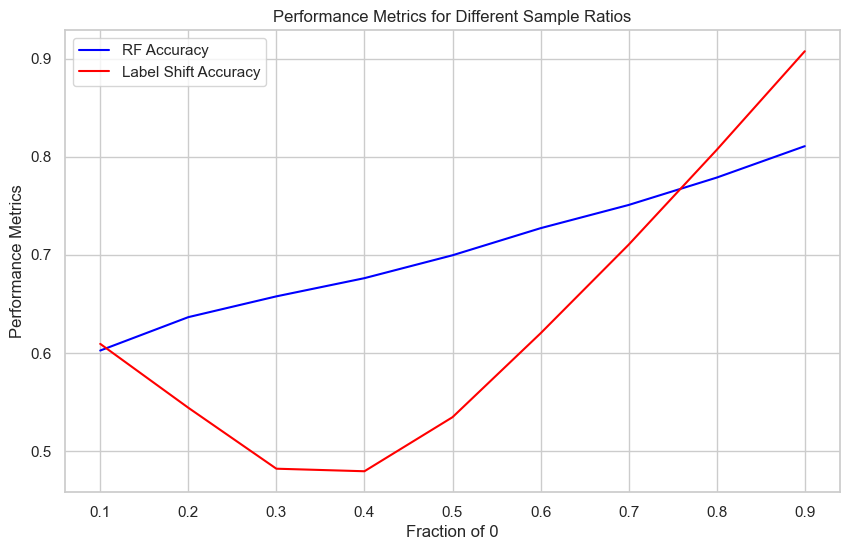

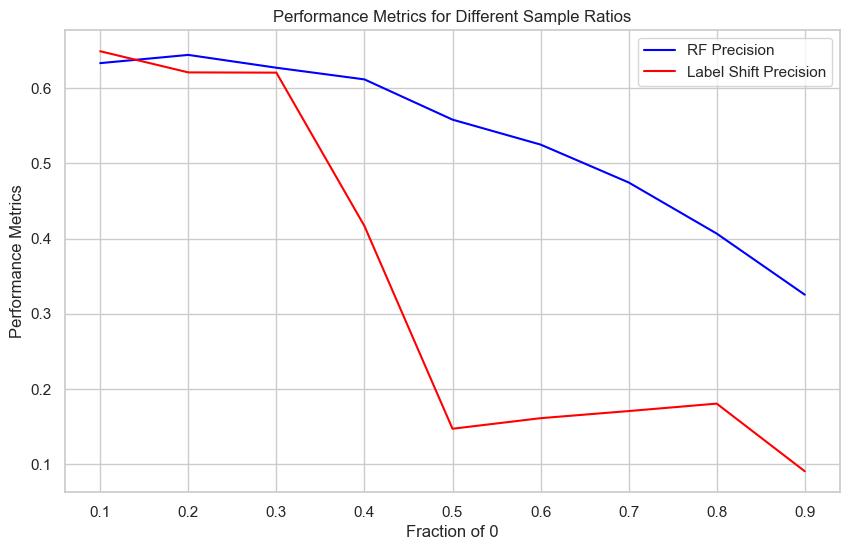

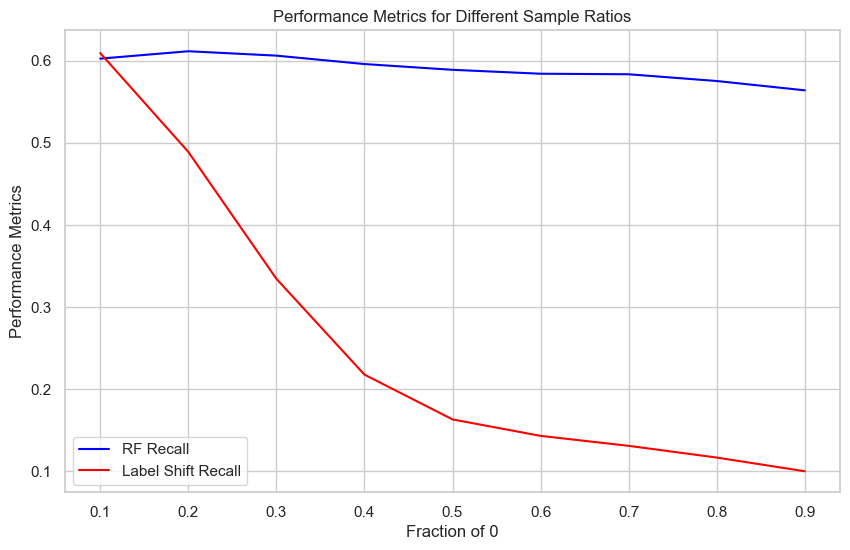

In [561]:
ls_accuracies, ls_precisions, ls_recalls = evaluate_models_label_shift(encoded_test, model, og)

In [497]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=3)
tsne = TSNE(n_components=3, random_state=0)

def visualize3D(X_train, y_train, reduction):
    # Dummy data for demonstration (replace X_train and y_train with your actual data)
    n, k = X_train.shape  # Example dimensions
    np.random.seed(0)  # For reproducible results

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Dimensionality reduction
    X_transformed = reduction.fit_transform(X_scaled)

    # Plotting in 3D space
    %matplotlib notebook

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Assign different colors for each class
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for i in range(3):
        ax.scatter(X_transformed[y_train.flatten() == i, 0], X_transformed[y_train.flatten() == i, 1], X_transformed[y_train.flatten() == i, 2], c=colors[i], label=f'Class {i}')

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.legend()
    plt.show()
    
def visualize2D(X_train, y_train, reduction):
    # Dummy data for demonstration (replace X_train and y_train with your actual data)
    n, k = X_train.shape  # Example dimensions
    np.random.seed(0)  # For reproducible results

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Dimensionality reduction
    X_transformed = reduction.fit_transform(X_scaled)

    # Plotting in 3D space
    %matplotlib notebook

    plt.figure()
    # Assign different colors for each class
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for i in range(3):
        plt.scatter(X_transformed[y_train.flatten() == i, 0], X_transformed[y_train.flatten() == i, 1], c=colors[i], label=f'Class {i}')

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.legend()
    plt.show()
    
# visualize3D(X_train[:1000, :], y_train[:1000], tsne)

In [563]:
def evaluate_models_online(test_datasets, model, og):
    # Prepare the test data
    
    accuracies = []
    precisions = []
    recalls = []
    ratios = []
    og_accuracies = []
    og_precisions = []
    og_recalls = []
    
    threshold_histories = {}
    prob_histories = {}
    

    for ratio, test_dataset in test_datasets.items():
        print('Test Bias Ratio: ', ratio)
        #print('Fitted thresholds: ', thresholds)
        
        X_test, y_test = zip(*[(x.detach().numpy().flatten(), y) for x, y in test_dataset])
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        
        model.reset_thresholds()
        predictions, threshold_history, prob_history = model.predict_biased_online(X_test, y_test, alpha = 0.1)
        threshold_histories[ratio] = threshold_history
        prob_histories[ratio] = prob_history
        accuracies.append(accuracy_score(y_test, predictions))
        og_accuracies.append(accuracy_score(y_test, og.predict(X_test)))
        og_precisions.append(precision_score(y_test, og.predict(X_test), average='macro'))
        og_recalls.append(recall_score(y_test, og.predict(X_test), average='macro'))
        precisions.append(precision_score(y_test, predictions, average='macro'))
        recalls.append(recall_score(y_test, predictions, average='macro'))
        ratios.append(ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_accuracies, label='RF Accuracy', color='blue')
    plt.plot(ratios, accuracies, label='DeBOT Accuracy', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_precisions, label='RF Precision', color='blue')
    plt.plot(ratios, precisions, label='DeBOT Precision', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_recalls, label='RF Recall', color='blue')
    plt.plot(ratios, recalls, label='DeBOT Recall', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    return threshold_histories, prob_histories, accuracies, precisions, recalls, og_accuracies, og_precisions, og_recalls

Test Bias Ratio:  0.1
Test Bias Ratio:  0.2
Test Bias Ratio:  0.3
Test Bias Ratio:  0.4
Test Bias Ratio:  0.5
Test Bias Ratio:  0.6
Test Bias Ratio:  0.7
Test Bias Ratio:  0.8
Test Bias Ratio:  0.9


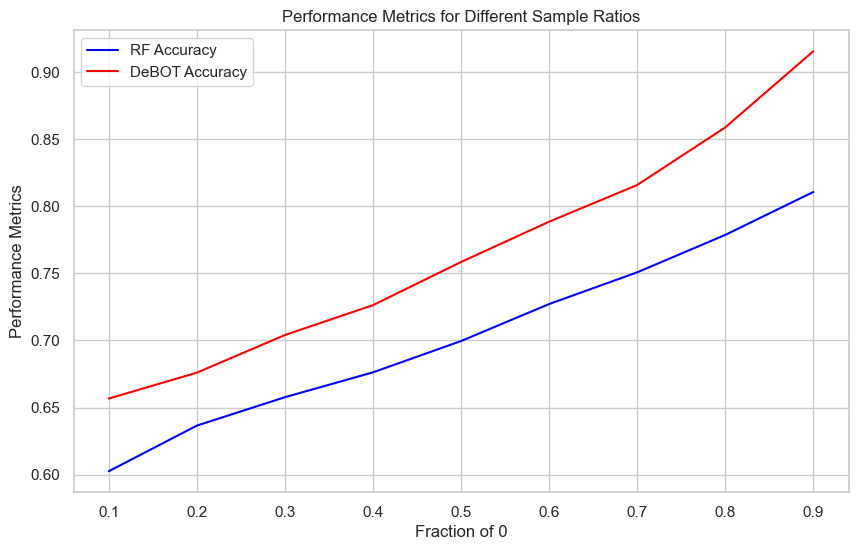

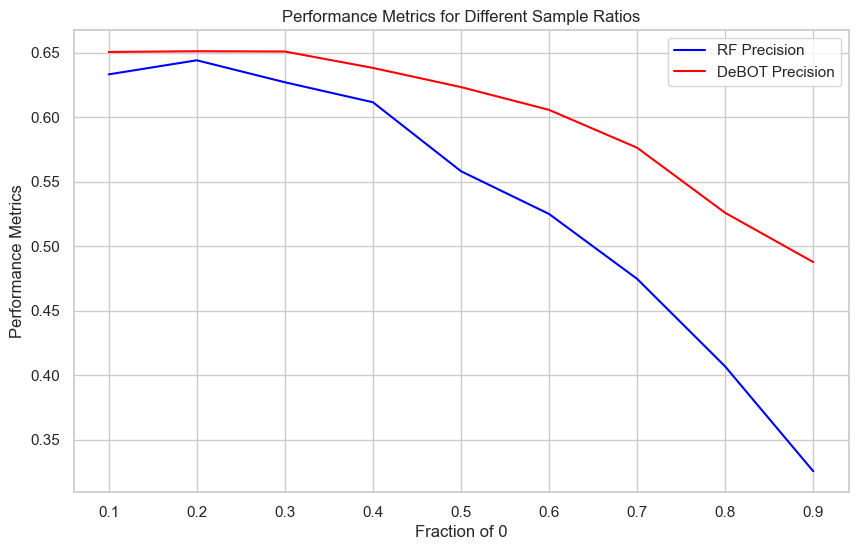

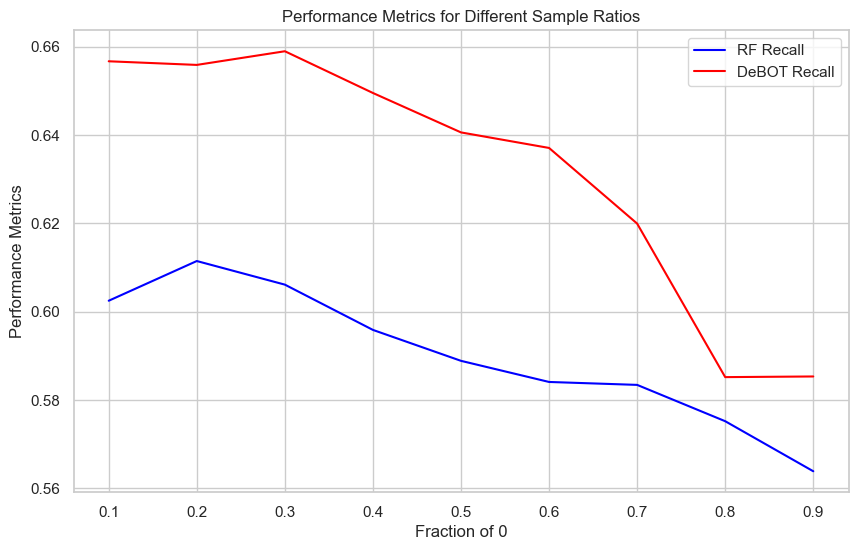

In [564]:
thresholds_hist, probs_hist, dba, dbp, dbr, rfa, rfp, rfr = evaluate_models_online(encoded_test, model, og)

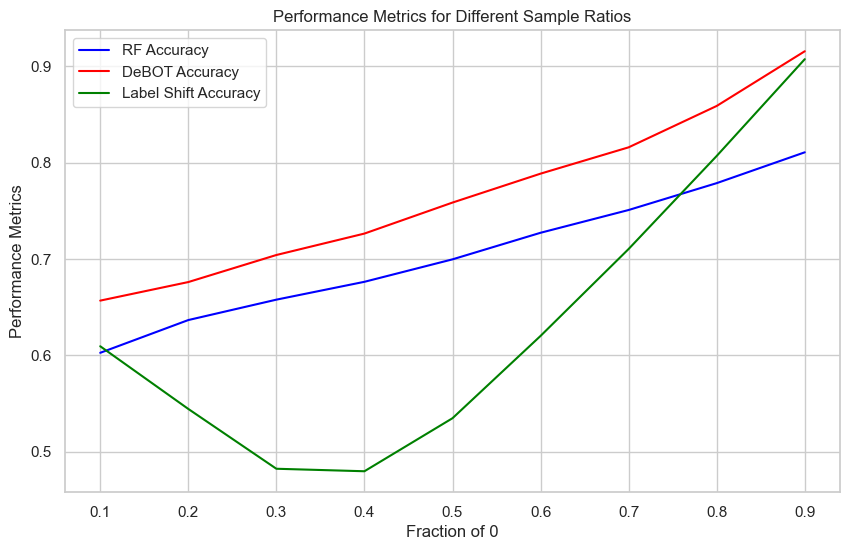

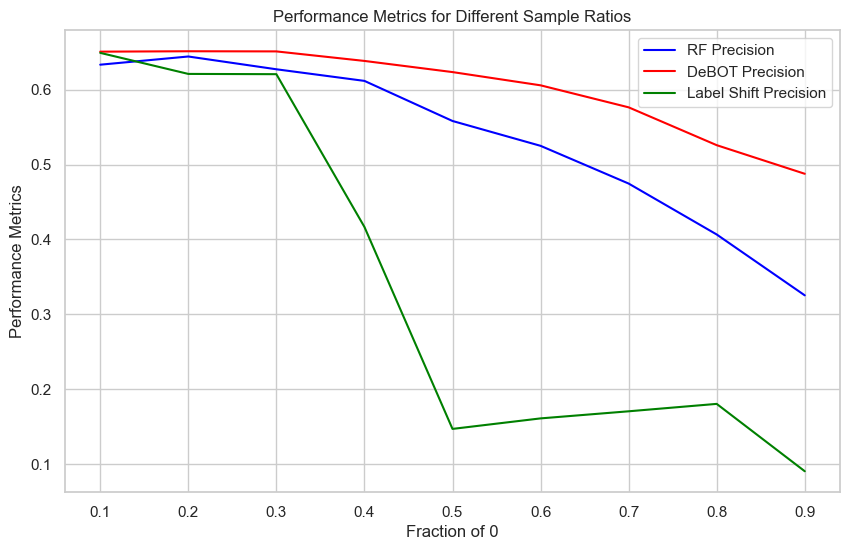

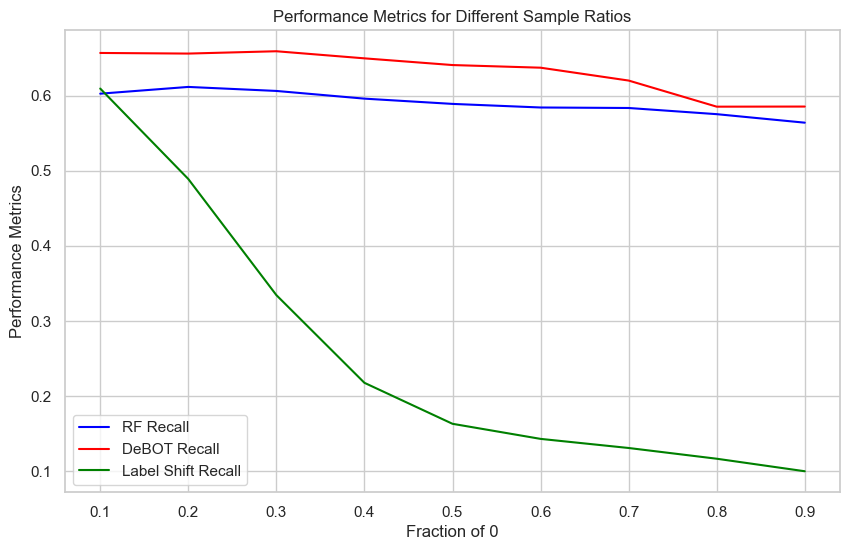

In [565]:
plt.figure(figsize=(10, 6))
plt.plot(ratios, rfa, label='RF Accuracy', color='blue')
plt.plot(ratios, dba, label='DeBOT Accuracy', color='red')
plt.plot(ratios, ls_accuracies, label='Label Shift Accuracy', color='green')

plt.xlabel('Fraction of 0')
plt.ylabel('Performance Metrics')
plt.title('Performance Metrics for Different Sample Ratios')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ratios, rfp, label='RF Precision', color='blue')
plt.plot(ratios, dbp, label='DeBOT Precision', color='red')
plt.plot(ratios, ls_precisions, label='Label Shift Precision', color='green')

plt.xlabel('Fraction of 0')
plt.ylabel('Performance Metrics')
plt.title('Performance Metrics for Different Sample Ratios')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(ratios, rfr, label='RF Recall', color='blue')
plt.plot(ratios, dbr, label='DeBOT Recall', color='red')
plt.plot(ratios, ls_recalls, label='Label Shift Recall', color='green')
e
plt.xlabel('Fraction of 0')
plt.ylabel('Performance Metrics')
plt.title('Performance Metrics for Different Sample Ratios')
plt.legend()
plt.grid(True)
plt.show()

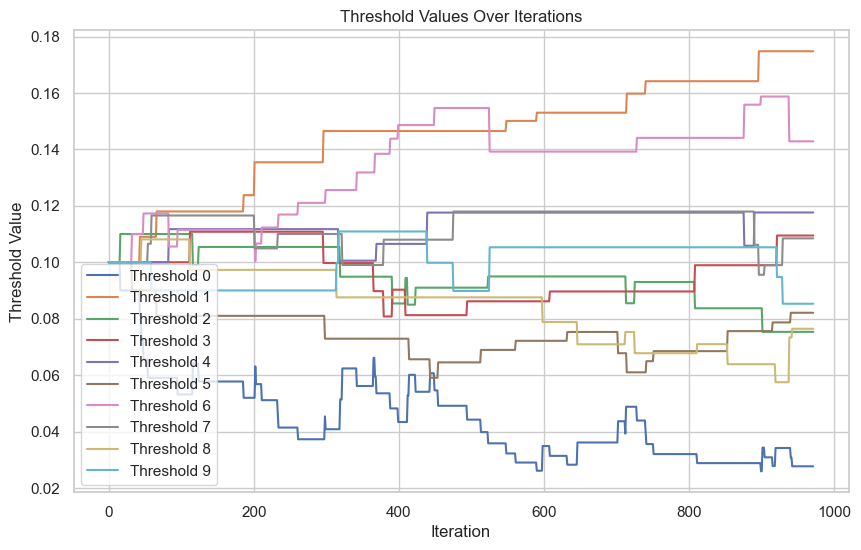

In [524]:
plot_threshold_history(thresholds_hist[0.9])

In [502]:
def get_gammas(probs_hist, thresholds_hist):
    k = len(probs_hist[0].flatten()) #number of classes
    init_gamma = [1] * k
    gamma_hist = [init_gamma]
    for probs, thresholds in zip(probs_hist, thresholds_hist):
        gamma = gamma_hist[-1].copy()
        curr = np.max(probs - thresholds, axis = 1)[0]
        y_p = np.argmax(probs - thresholds, axis = 1)[0]
        gamma[y_p] = min(gamma[y_p], curr)
        gamma_hist.append(gamma)
    return gamma_hist

def get_gammas_with_orig(probs_hist, thresholds_hist):
    #always use the last thresholds value
    k = len(probs_hist[0].flatten()) #number of classes
    gamma = [1] * k
    thresholds = thresholds_hist[-1]
    for probs in probs_hist:
        curr = np.max(probs - thresholds, axis = 1)[0]
        y_p = np.argmax(probs - thresholds, axis = 1)[0]
        gamma[y_p] = min(gamma[y_p], curr)
    return gamma

def get_gammas_without_orig(probs_hist, thresholds_hist):
    return get_gammas(probs_hist, thresholds_hist)[-1]

In [503]:
gammas = []
w_arr = []
thresholds = []
# for ratio in probs_hist:
#     if len(w_arr) == 0:
#         w_arr = get_exp_probs(ratio)
#     w_arr.append(ratio)
#     probs = probs_hist[ratio]
#     th = thresholds_hist[ratio]
#     gamma = get_gammas_with_orig(probs, th)
#     gammas.append(gamma[0])
#     thresholds.append(th[-1][0])
    
# for ratio in probs_hist:
#     w_arr += list(get_exp_probs(ratio))
#     probs = probs_hist[ratio]
#     th = thresholds_hist[ratio]
#     gamma = get_gammas_with_orig(probs, th)
#     gammas += gamma
#     thresholds += th[-1]

for ratio in probs_hist:
    w_arr.append(ratio)
    probs = probs_hist[ratio]
    th = thresholds_hist[ratio]
    gamma = get_gammas_with_orig(probs, th)
    gammas.append(gamma[0])
    thresholds.append(th[-1][0])


# gammas = np.array(gammas)
# gamma_avg = gammas.mean(axis = 0)
# gamma_std = gammas.std(axis = 0)

# thresholds = np.array(thresholds)
# thresholds_avg = thresholds.mean(axis = 0)
# thresholds_std = thresholds.std(axis = 0)

In [597]:
def compute_gamma_train(X_train, y_train, thresholds):
    probs_hist = model.predict_proba(X_train)
    gamma_init = [1/model.n_classes] * model.n_classes
    gamma_hist = [gamma_init]
    for i, probs in enumerate(probs_hist):
        gamma = gamma_hist[-1].copy()
        y_p = y_train[i]
        diff = probs - thresholds
        curr = diff[y_p]
        gamma_curr = curr
        gamma[y_p] = min(gamma[y_p], gamma_curr)
        gamma_hist.append(gamma)
    return gamma_hist[-1]

def compute_gamma_train_2(X_train, y_train, thresholds):
    probs_hist = model.predict_proba(X_train)
    gamma_init = [1/model.n_classes] * model.n_classes
    gamma_hist = [gamma_init]
    for i, probs in enumerate(probs_hist):
        gamma = gamma_hist[-1].copy()
        y_p = y_train[i]
        diff = probs - thresholds
        curr = diff[y_p]
        diff[y_p] = -1e9
        max_other = max(diff)
        gamma_curr = curr - max_other
        gamma[y_p] = min(gamma[y_p], gamma_curr)
        gamma_hist.append(gamma)
    return gamma_hist[-1]
    
gamma_final = [compute_gamma_train(X_train, y_train, thresholds_hist[ratio][-1][0])[0] for ratio in thresholds_hist]

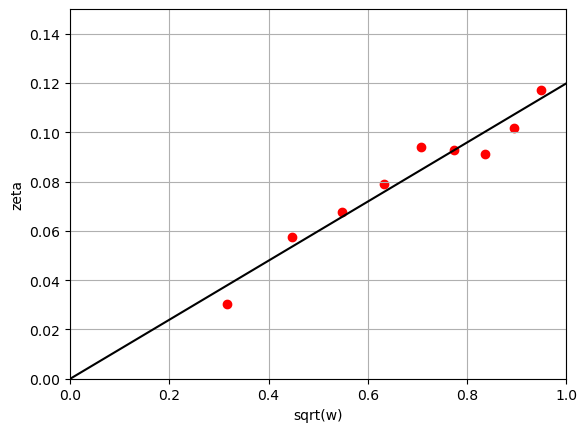

In [634]:
w_sqrt = np.sqrt(w_arr)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(np.array(w_sqrt).reshape(len(w_arr), 1), gamma_final)
c = reg.intercept_

gammas = gamma_final - c
x_plot = np.arange(0, 2, 0.1)
x_plot = x_plot.reshape((len(x_plot), 1))
y_plot = reg.predict(x_plot) - c
error = [0.01] * len(w_sqrt)



plt.style.use('default')  # You can choose other styles like 'ggplot', 'bmh', etc.

fig, ax = plt.subplots()
fig.patch.set_alpha(0.5)  # Sets the background of the figure as transparent
ax.patch.set_alpha(0.5)  # Sets the background of the axes as transparent

# Creating the plot
ax.plot(x_plot, y_plot, label='Line Plot', color = 'black')
ax.scatter(w_sqrt, gammas, color='red', label='Scatter Plot')
#ax.errorbar(w_sqrt, gammas, yerr=error, fmt='o', color='red', label='Error Bars')
ax.grid(True)


ax.set_xlim([0, 1])
ax.set_ylim([0, 0.15])

ax.set_xlabel('sqrt(w)')
ax.set_ylabel('zeta')
plt.show()

(0.0, 0.12)

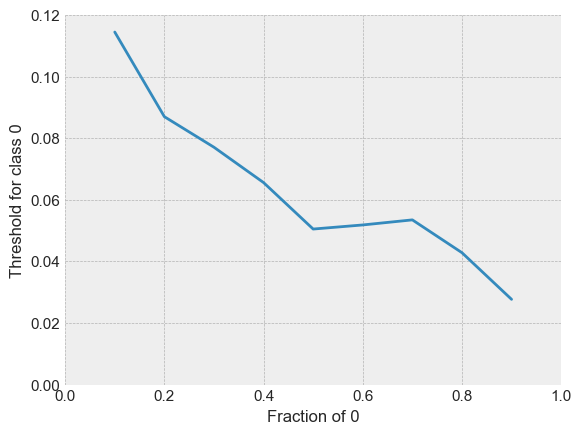

In [629]:
plt.plot(w_arr, thresholds)
plt.xlabel('Fraction of 0')
plt.ylabel('Threshold for class 0')
plt.xlim([0, 1])
plt.ylim([0, 0.12])

(0.0, 0.05)

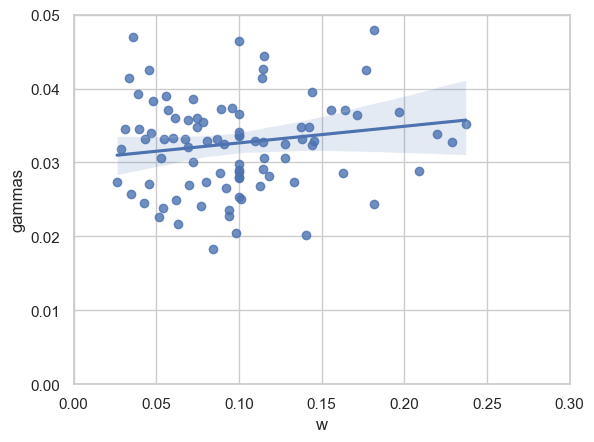

In [477]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame(np.transpose([w_arr, gammas]), columns = ['w', 'gammas'])
sns.regplot(data, x = 'w', y = 'gammas')

# from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(np.array(w_arr).reshape(len(w_arr), 1), gammas)
# x_plot = np.arange(0, 3, 0.1)
# x_plot = x_plot.reshape((len(x_plot), 1))
# y_plot = reg.predict(x_plot)

# # Use Seaborn to set the style
# sns.set(style="whitegrid")

# # Create the scatter plot with error bars using Matplotlib
# plt.plot(x_plot, y_plot)
# plt.scatter(w_arr, thresholds)
# #plt.errorbar(w_arr, gamma_avg, yerr=gamma_std, fmt='o', ecolor='black', capthick=2)
plt.xlim([0, 0.3])
plt.ylim([0, 0.05])

# # Show the plot
# plt.show()

## Old code for visualization and plotting

In [ ]:
w_arr = []
gamma_arr = []
thresholds_arr = []
for ratio in probs_hist:
    prob_ratios = get_exp_probs(ratio)
    w_arr += [ratio]
    gamma_arr += [get_gammas(probs_hist[ratio], thresholds_hist[ratio])[-1][0]]
    thresholds_arr.append(thresholds_hist[ratio][-1][0])

In [ ]:
%matplotlib inline
w_power = np.power(w_arr, 0.5)
w_power = np.array(w_power).reshape(len(w_power), 1)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(w_power, thresholds_arr)
x_plot = np.arange(0, 2, 0.1)
x_plot = x_plot.reshape((len(x_plot), 1))
y_plot = reg.predict(x_plot)

plt.plot(x_plot, y_plot)
plt.scatter(w_power, thresholds_arr)
plt.xlim([0, 1])
plt.ylim([0, 0.2])
plt.show()

<IPython.core.display.Javascript object>


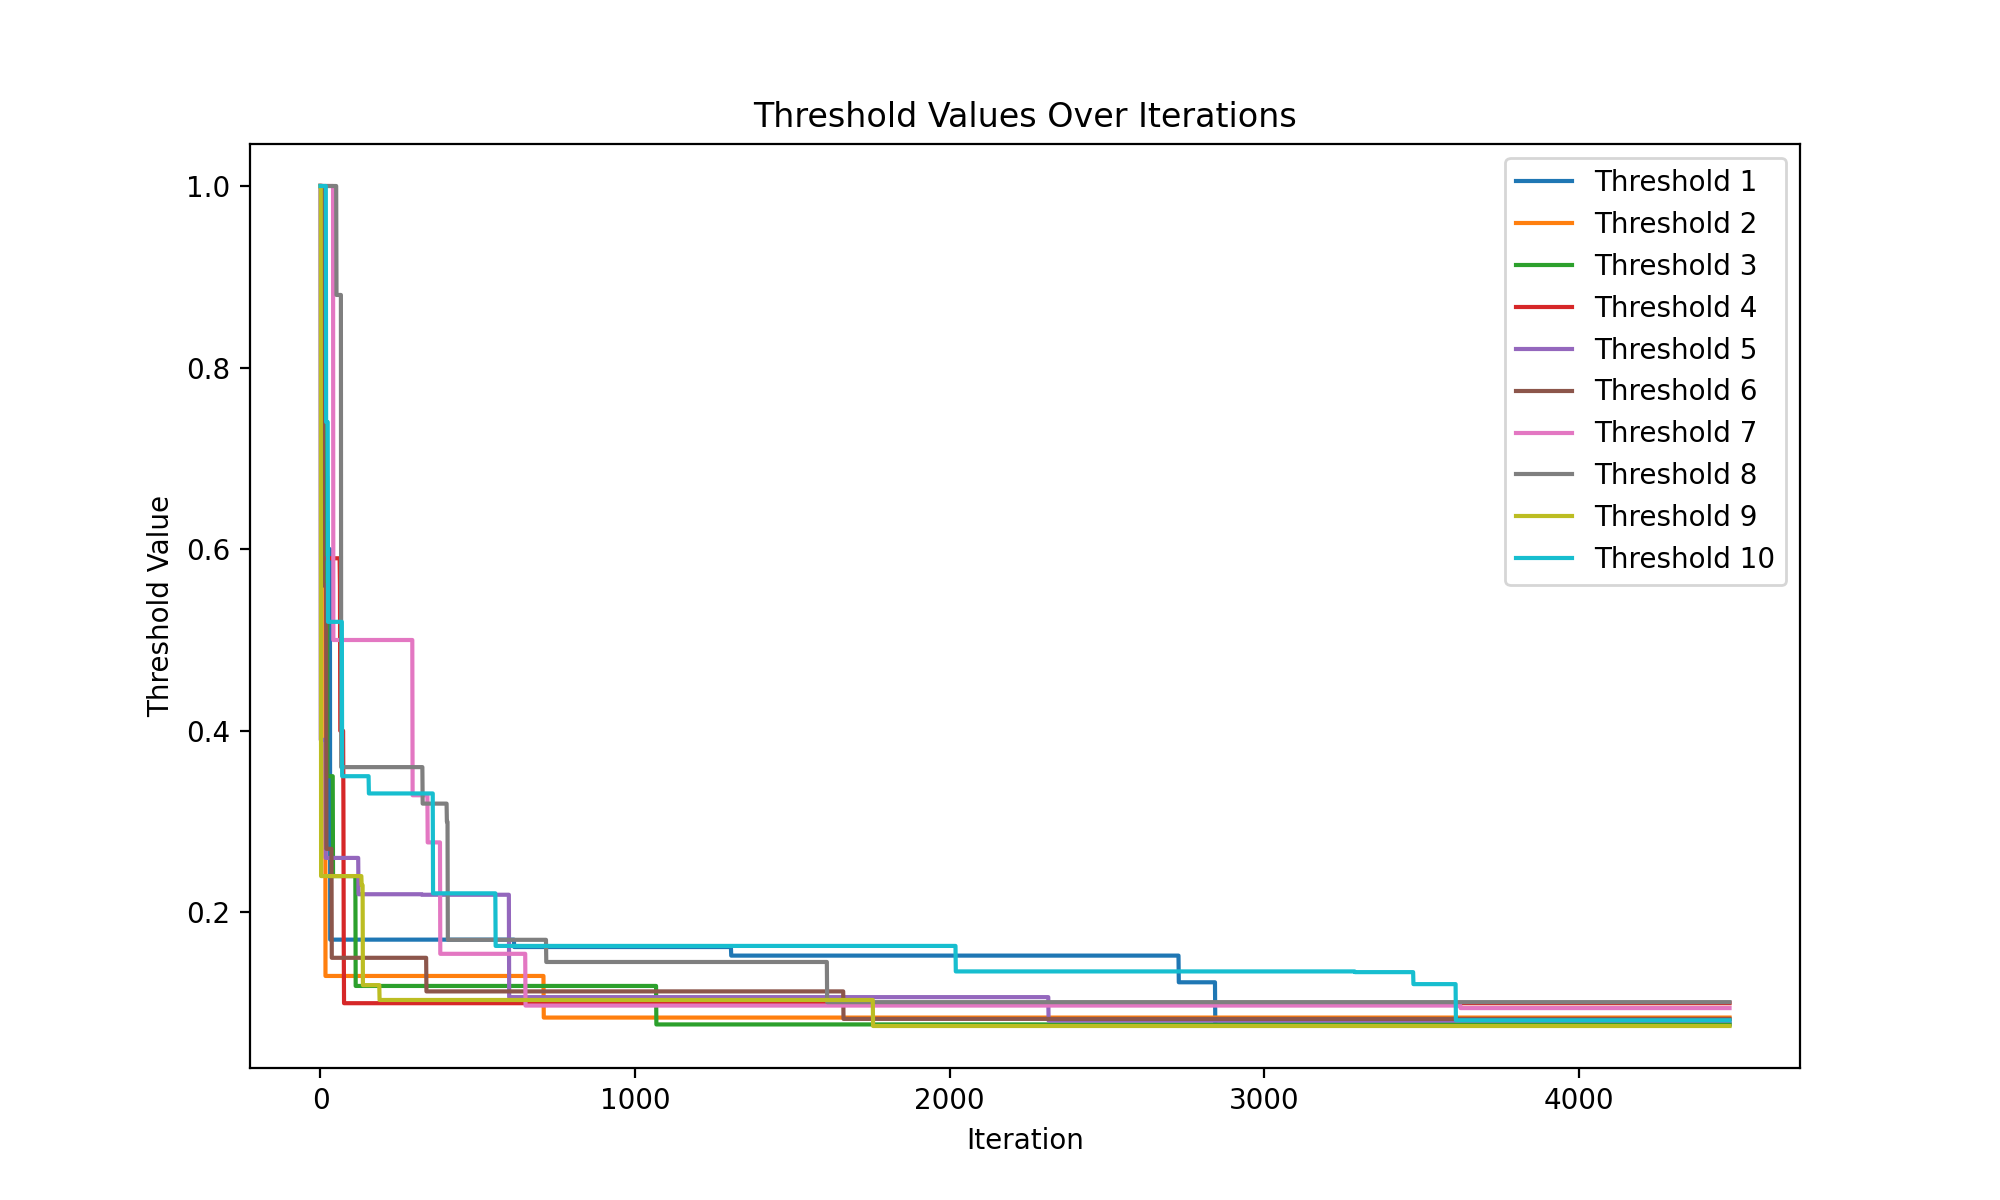

In [70]:
plot_threshold_history(histories[1][0.2])